# Brain Decoding Time! 

This is a notebook containing the code to my brain decoding tutorial, based on nilearn's [introductory tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).

The neuroscience and machine learning concepts are covered in their corresponding files included in the repo. The documentation included here is focused on the implementation of the theory into code. Please read the `fMRI_Crash_Course.md` and the `ML_Crash_Course.ipynb` files before proceeding! In fact, it may be beneficial to have all these files open simultaneously, as brain decoding requires the understanding of many concepts.

In [1]:
# This is an IPython magic command. Usually, after creating a plot with matplotlib, you must do plt.show() to see it.
# This command makes it so that the plot will automatically show when you run a cell, without the show() command.

%matplotlib inline

# This line is for debugging purposes (to measure how much memory is being used) and so you can disregard it.
%load_ext memory_profiler

## Downloading the data

In this tutorial, we will be working with a dataset from Haxby's 2001 [study](http://haxbylab.dartmouth.edu/publications/HGF+01.pdf) on visual representations in the brain. The data is provided by PyMVPA and has been made openly available under the [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license. For information on acquisition parameters, please see the [link](http://www.pymvpa.org/datadb/haxby2001.html) from which this data was retrieved.

If this is the first time you are running this, the `nilearn.datasets.fetch_haxby` function will download subject 2 (by default) from the Haxby dataset into a nilearn created path on your computer. It is about 310 MB of data so it may take a little while to download.

Optional parameters:

- If you wish to specify the directory where the download should take place, you can use the `data_dir` parameter, which takes a string.

- If you wish to retrieve other subjects, use the `subjects` parameter, which takes a list or an int.

In [2]:
from nilearn import datasets

ds = datasets.fetch_haxby()

/Users/normankong/Desktop/decoding/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


What is returned from this function is a nilearn dict-like object containing different 'keys' to different parts of the data. To view, simply run the next cell:

In [3]:
print(ds)

{'anat': ['/Users/normankong/nilearn_data/haxby2001/subj2/anat.nii.gz'], 'func': ['/Users/normankong/nilearn_data/haxby2001/subj2/bold.nii.gz'], 'session_target': ['/Users/normankong/nilearn_data/haxby2001/subj2/labels.txt'], 'mask_vt': ['/Users/normankong/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz'], 'mask_face': ['/Users/normankong/nilearn_data/haxby2001/subj2/mask8b_face_vt.nii.gz'], 'mask_house': ['/Users/normankong/nilearn_data/haxby2001/subj2/mask8b_house_vt.nii.gz'], 'mask_face_little': ['/Users/normankong/nilearn_data/haxby2001/subj2/mask8_face_vt.nii.gz'], 'mask_house_little': ['/Users/normankong/nilearn_data/haxby2001/subj2/mask8_house_vt.nii.gz'], 'mask': '/Users/normankong/nilearn_data/haxby2001/mask.nii.gz', 'description': b'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distribut

In the next cell, we will store the paths of:

- the bold file (`bold.nii.gz`, stored in the `func` key)
- A mask of the ventral temporal stream (`mask_vt.nii.gz`, stored in the `mask_vt` key)
- An anatomical image of the subject (`anat.nii.gz`, stored in the `anat` key)
- The labels of each image (`labels.txt`, stored in the `session_target` key)

so that we can easily refer to them. Note that the paths are stored in lists, so we must access them by index.

In [4]:
bold_path = ds.func[0]
mask_path = ds.mask_vt[0]
anat_path = ds.anat[0]
labels_path = ds.session_target[0]

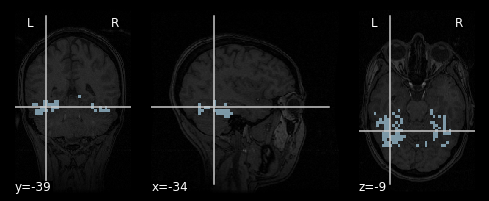

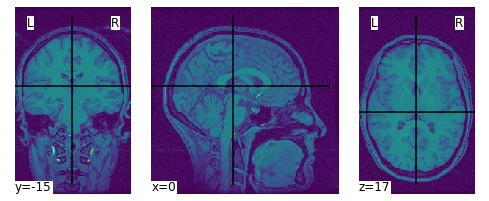

In [5]:
# Here, we will quickly take a quick look at the data we are working with:

from nilearn import plotting

# TODO: what is cmap='Paired' ??

# The mask overlaid onto the subject's anatomical scan
plotting.plot_roi(mask_path, bg_img=anat_path, cmap='Paired')

# The anatomical image itself
plotting.plot_img(anat_path)

## Converting the Mask to a Usable Matrix

The first thing we have to do before manipulating brain data is to turn it into a form that we can use. That means converting the raw data (ie, a NIfTI file) into a usable format (ie, a *flattened* numerical matrix).

To do this, we will use nilearn's "masker" object.

Note: Masker objects apply some basic preprocessing steps with common parameters by default. For now, all preprocessing is outside the scope of this tutorial, but _may_ be added in the future. 

The "masker" object will not only do this conversion for us, but we will use it to apply a *mask image* to our data. A mask is a binarized version of our brain image that will help us filter the information we want from our BOLD file. Masks essentially "hide" the parts of the brain that we are not interested in by multiplying their values by 0. 

Here is a simplified example:

Let's say our brain scan was represented by a 3x3 matrix:

\begin{equation}
  \begin{bmatrix}
    32 & 65 & 125 \\
    56 & 4 & 73 \\
    35 & 232 & 28 \\
  \end{bmatrix}
  \label{eq:aeqn}
\end{equation}

If we were only interested in the activations in the right side of our brain, a mask could look like this:

\begin{equation}
  \begin{bmatrix}
    0 & 0 & 1 \\
    0 & 0 & 1 \\
    0 & 0 & 1 \\
  \end{bmatrix}
  \label{eq:aeq}
\end{equation}

By applying the mask to the brain scan, we can isolate the parts of the brain we are interested in. One main application of this is for dimensionality reduction. We lessen the information we are processing in order to speed up the computation. 

In this tutorial, we are interested only in activation patterns within the ventral temporal stream, so we apply a mask using the corresponding mask provided by Haxby's dataset.  

***

It is easy to get confused by the dimensionality of our files, so let's go through it carefully.

To begin, remember that the mask and the BOLD data are the same shape. Each brain volume (and the mask) is a (40, 64, 64) volume of voxels. However, the BOLD file also has the dimension of time, and so displays a 4th dimension containing 1452 time stamps. 

In [6]:
import nibabel as ni

bold = ni.load(bold_path) # load bold image into memory as a nibabel image
msk = ni.load(mask_path) # load mask image into memory as a nibabel image
msk_data = msk.get_data() # get the physical data of the mask (3D matrix of voxels)

print(bold.shape)
print(msk.shape) 
print(len(msk_data[msk_data==1]))

(40, 64, 64, 1452)
(40, 64, 64)
464


Note that the last line shows us how many voxels are considered 'important' by the mask; that is, how many voxels have a value == 1. The BOLD file is a 4D collection of brain volumes, each (40, 64, 64). There are 1452 of them, one for each time point.

Now, let's create the masker object with our ventral temporal mask.

In [7]:
from nilearn.input_data import NiftiMasker

# We must first create the masker object 
masker = NiftiMasker(mask_img=mask_path, standardize=True)

We set standardize option to `True` because...  <br>
TODO: Why is standardizing necessary/beneficial?

***

Now, let's apply our masker to the BOLD data. Remember, this will convert the numbers of the BOLD file into a usable, flattened matrix *and* apply the mask.

In [8]:
# Creating a numpy matrix from the BOLD data, using the mask for the transformation
%memit bold_masked = masker.fit_transform(bold_path)

peak memory: 2296.23 MiB, increment: 2179.75 MiB


So to recap, the `bold_masked` file is no longer really an 'image' but rather it is a 2D numpy  matrix containing the BOLD data, after being flattened and having the mask transformation applied. 

In [9]:
print(bold_masked.shape)

(1452, 464)


The shape of the bold data is now (1452, 464). We still have the 1452 samples, because we still have 1452 time points, but the second dimension is due to the fact that we applied the masker object. It applied the mask onto the data, and so gave us only the important values (464 of them) and then flattened the 3D array into one long array of numbers. So in sum, the masker converted the 4D BOLD data into a 2D matrix (timepoint x voxels). 

So note that while the mask itself contains values for each voxel in the brain (==0 or ==1), the bold file after being masked only contains the voxels of the brain that we are interested in (so that were ==1 in the mask). You may be wondering "well, didn't we lose information by only keeping the voxels we care about, because we don't know which voxel is which if there were all concatenated into a single array?". It's a good question, but we know the location of the voxels because the masker objects stores the mapping information from brain space to the flattened space of the matrix. 

Note: `bold_masked` will be masked twice: the first time, to keep only the voxels related to the ventral temporal stream, and a second time when we want only the BOLD signal related to faces and cats.

In [10]:
# Viewing the dimensions of the matrix
# The shape represents the number of time-stamps by the number of voxels in the mask, 
print(bold_masked.shape)

# Viewing the numerical values of the matrix
print(bold_masked)

(1452, 464)
[[ 7.6757914e-01  2.3108709e+00 -2.0519446e-01 ... -1.0261141e+00
   8.7993503e-02  2.0720530e+00]
 [ 5.5640829e-01  1.6833442e+00 -2.4644940e-01 ... -7.0238096e-01
  -3.4570050e-01  2.0341012e+00]
 [ 7.6757914e-01  1.9186667e+00  1.0802227e-03 ... -9.9374086e-01
  -2.7630946e-01  2.1479564e+00]
 ...
 [-4.2905572e-01 -1.6896113e+00 -7.4150860e-01 ... -1.5440873e+00
   1.8054218e+00 -1.6709729e-01]
 [-1.4749458e-01 -1.8072726e+00 -2.4644940e-01 ... -1.7707006e+00
   1.5452055e+00  7.8169519e-01]
 [-2.1788488e-01 -1.4542887e+00  1.0802227e-03 ... -1.6412073e+00
   1.2676412e+00  8.9555031e-01]]


Now, we'll prepare the labels of our data points. This consists of strings that categorize what the subject was seeing (ex: 'shoe', 'house, etc). This is stored in the `labels.txt` file.

In [11]:
# Load the labels from a csv into an array using pandas

import pandas as pd

stimuli = pd.read_csv(labels_path, sep=' ')

In [12]:
# Viewing the dimensions of the matrix
print(stimuli.shape)

# Viewing the values of the matrix
print(stimuli)

(1452, 2)
     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


The first column is the number of time-stamps, and the second dimension contains the labels and the chunks.

TODO: What is `chunks`?

We are only interested in the labels, so let's pick those out from the `targets` array.

In [13]:
targets = stimuli['labels']

Now, we have isolated the prediction targets in the `targets` variable.

In [14]:
print(targets)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


For this tutorial, we will restrict the analysis to differentiate only between faces and cats. For this, we will use pandas' `DataFrame.isin(self, values)` function. This will return a new `DataFrame` of booleans (`targets_mask`) showing whether the value(s) in the `values` argument (`'face'` and `'cat'`) is contained within the `DataFrame` (`targets`). 

In [15]:
targets_mask = targets.isin(['face', 'cat'])

Given that the returned DataFrame contains only boolean values, we use it as a mask, because it indicates which values we are interested in (ie, `False` for samples we don't care about, and `True` for samples that we do care about; that is, for samples where the subject was shown faces or cats).

In [16]:
print(targets_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool


We will now apply this mask so that the BOLD data will only contain the scans relevant to faces and cats.

In [17]:
bold_masked = bold_masked[targets_mask]

`bold_masked` now contains less samples, because we are only looking at the samples where the subject is looking at a face or a cat.

In [18]:
bold_masked.shape

(216, 464)

We have to also apply this mask to our labels matrix.

In [19]:
targets_masked = targets[targets_mask]

In [20]:
print(targets_masked.shape)
print(targets_masked)

(216,)
21      face
22      face
23      face
24      face
25      face
        ... 
1427     cat
1428     cat
1429     cat
1430     cat
1431     cat
Name: labels, Length: 216, dtype: object


## Training Machine Learning Models

Now that our data is in a format that we can work with, it is time to train some models.

For this section, we will be using the sci-kit learn library.

***
Note that 'opt' is short for 'optional', and 'req' is short for 'required'.
***
Note: I have briefly explained what each parameter does, but for an exhaustive list of the possibilities, please see the documentation listed below.

### k-Nearest Neighbours

Main steps:
1. Split data into testing and training sets
2. Fit the model 
3. Make predictions, and compute accuracy

First, we'll shuffle the data, then dedicate 70% of it for training, and 30% of it for testing. This is done using sklearn's `train_test_split` method. The method call in this tutorial is as follows:

`train_test_split(bold_masked, targets_masked, test_size=0.3, random_state=42, shuffle=True)`

- `bold_masked`: the samples of the data.
- `targets_masked`: the labels of the data.
- `test_size`: the proportion of the dataset to be used for the testing.
- `random_state`: this is the seed which is used by the random number generator. if it is defined by the user, you will keep the same random state every time it is run. 
- `shuffle`: Whether or not to shuffle the data before splitting. This is recommended in order avoid biased training and testing sets.

This will return 2 times as many matrices as you give it. In this example, we gave it 2 matrices (`bold_masked` and `targets_masked`) and so we are returned 4 matrices, which are our training samples, testing samples, training labels and testing labels, all contained within their own lists. These are defined using list unpacking.

In [21]:
# Shuffling the data then splitting it into 70-30 split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bold_masked, targets_masked, test_size=0.3, random_state=42, shuffle=True)

Now, it is time to create our model. We do this by creating a `KNeighborsClassifier()` object, which has the fit and predict methods.

This object has several parameters, explained here:

- `n_neighbours`(opt, int, default=5): The number of neighbours to use to determine the label (aka, your 'k' value).
- `metric` (opt, str or callable, default=`'minkowski'`): The metric (or function) to use to compute the distance between points.
- `metric_params`(opt, dict, default=`None`): Additional keyword arguments for the metric function. 
- `weights`: The weight function to be used in prediction. That is, you can decide how the closest points to the unknown point are weighed. If unspecified, the default is `'uniform'`, which means all neighbouring points are weighted equally.
- `algorithm` (opt, str, default=`'auto'`): The algorithm used to compute the nearest neighbors. These include: `ball_tree`, `kd_tree`, `brute` and `auto`. 
- `leaf_size` (opt, str, default='30'): The leaf size passed to BallTree or KDTree. 
- `p` (opt, int, default=2): The power parameter for the Minkowski metric.
- `n_jobs`(opt, int, default=`None`): The number of computations to run in parallel for the neighbors search. `None` will assign 1 core, and `-1` will assign all the available cores. 

In [22]:
# Create and fit (train) a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

The `fit` method is a general sci-kit learn method that usually trains the model on the training data. However, kNNs don't really "train" and so in this class, all this method does is store the training samples and labels in memory. 

In [23]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Now, let's see how well our model does! First, we'll store its predictions in a variable called `y_pred`.

In [24]:
y_pred = knn.predict(X_test)

Then, we can use sklearn's `accuracy_score` method to see the percentage of labels our model predicted correctly.

In [25]:
from sklearn.metrics import accuracy_score

scores = accuracy_score(y_test, y_pred)

print(scores)

0.9384615384615385


### Logistic Regression: coming soon!

And that's it! This tutorial really covers the most basic cases of machine learning, but I highly recommend you tamper with the parameters, and even try your own models! As you've seen, scikit learn makes it extremely easy to start playing with different models and parameters.

### Documentation:

Preparing the data: https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html

***

**k-Nearest Neighbours**:

`train_test_split`:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

`KNeighborsClassifier()`:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

`accuracy_score`:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

**Logistic Regression**:

**Support Vector Machine**:

**Convolutional Neural Network**: